In [ ]:
import sys
import os

# add the main directory to the notebook
sys.path.append(os.path.abspath(os.path.join('/home/lazaror/quantum/pruebas/EQCNN_local_testing/EQNN_for_HEP')))

import numpy as np
from Equivariant_QCNN.data.data import data_load_and_process
from Equivariant_QCNN.training.Training import circuit_training
from Equivariant_QCNN.models.QCNN_circuit import QCNN
import matplotlib.pyplot as plt
from Equivariant_QCNN.benchmarking.Benchmarking import accuracy_test, round_predictions_f
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-09-16 17:04:12.122869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
"""
Here are possible combinations of benchmarking user could try.
Unitaries: ['U_TTN', 'U2_equiv', 'U4_equiv', 'U_5', 'U_6', 'U_9', 'U_13', 'U_14', 'U_15', 'U_SO4', 'U_SU4', 'U_SU4_no_pooling', 'U_SU4_1D', 'U_9_1D']
U_num_params: [2, 6, 6, 10, 10, 2, 6, 6, 4, 6, 15, 15, 15, 2]
feature_reduction: ['img16x16x1','resize256', 'pca8']
embedding_type: ["Equivariant-Amplitude", "Amplitude", "Angle"]
dataset: 'mnist' or 'fashion_mnist'
circuit: 'QCNN' 
cost_fn: 'mse' or 'cross_entropy'
Note: when using 'mse' as cost_fn binary="True" is recommended, when using 'cross_entropy' as cost_fn must be binary="False".
"""


# invariant testings

# U2_equiv is invariant under p4m using MSE
# U2_equiv is invariant under reflections over X using cross_entropy 


params = np.random.random(35)
U_params = 6
U = "U2_equiv"
embedding_type = "Equivariant-Amplitude"
circuit = "QCNN"
cost_fn = "mse"
binary = True

X_train, X_test, Y_train, Y_test = data_load_and_process( "fashion_mnist", [0,1], "img16x16x1", binary)

print(X_train.shape)

(12000, 16, 16, 1)


 Output with Probabilities for Original Image: -0.0015391303082348713
 Output with Probabilities for Image Reflected over Y-axis: -0.0015391303082348713
 Output with Probabilities for Image Reflected over X-axis: -0.0015391303082348661
 Output with Probabilities for Image Rotated 90 Degrees: -0.001539130308234762


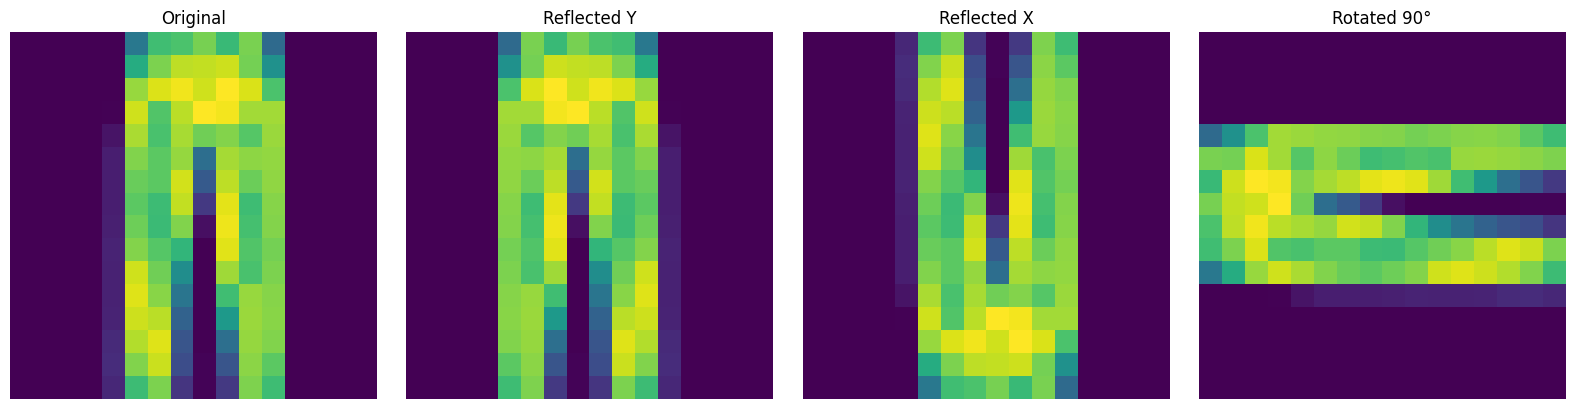

In [5]:
#data and transformed data
matrix = np.array(X_train[4])
matrix_reflected_y = np.fliplr(matrix) # Image Reflected over Y-axis
matrix_reflected_x = np.flipud(matrix) # Image Reflected over X-axis
matrix_rotated_90 = np.rot90(matrix) # Image rotated 90 degrees


result1 = QCNN(matrix, params, U, U_params, embedding_type, cost_fn)
result2 = QCNN(matrix_reflected_y, params,U, U_params, embedding_type, cost_fn)
result3 = QCNN(matrix_reflected_x, params, U, U_params, embedding_type, cost_fn)
result4 = QCNN(matrix_rotated_90, params, U, U_params, embedding_type, cost_fn)

print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")
print(f" Output with Probabilities for Image Rotated 90 Degrees: {result4}")

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.title('Original')
plt.imshow(matrix)
plt.axis('off')  

plt.subplot(1, 4, 2)
plt.title('Reflected Y')
plt.imshow(matrix_reflected_y)
plt.axis('off') 

plt.subplot(1, 4, 3)
plt.title('Reflected X')
plt.imshow(matrix_reflected_x)
plt.axis('off')  

plt.subplot(1, 4, 4)
plt.title('Rotated 90°')
plt.imshow(matrix_rotated_90)
plt.axis('off') 

plt.tight_layout()  
plt.show()

In [9]:
# train for 25 epochs
loss_history, train_acc, trained_params = circuit_training(X_train, Y_train, U, U_params, embedding_type, circuit, cost_fn, steps = 10, initial_learning_rate=0.1)

iteration:  0  cost:  0.9779689456100886 train_accuracy: 0.587890625
iteration:  1  cost:  0.9068654555717147 train_accuracy: 0.646484375
iteration:  2  cost:  0.9323040696599315 train_accuracy: 0.787109375
iteration:  3  cost:  0.9005328374361308 train_accuracy: 0.748046875
iteration:  4  cost:  0.8785157036105787 train_accuracy: 0.8125
iteration:  5  cost:  0.8556176209314302 train_accuracy: 0.80078125
iteration:  6  cost:  0.7969541323165733 train_accuracy: 0.69921875
iteration:  7  cost:  0.7395522909702021 train_accuracy: 0.69921875
iteration:  8  cost:  0.8338092375173097 train_accuracy: 0.79296875
iteration:  9  cost:  0.7501511206584638 train_accuracy: 0.85546875
Learning rate reduced to: 0.05


In [10]:
predictions = [QCNN(x, trained_params, U, U_params, embedding_type, cost_fn) for x in X_test]

accuracy = accuracy_test(predictions, Y_test, cost_fn, binary)
accuracy

0.852

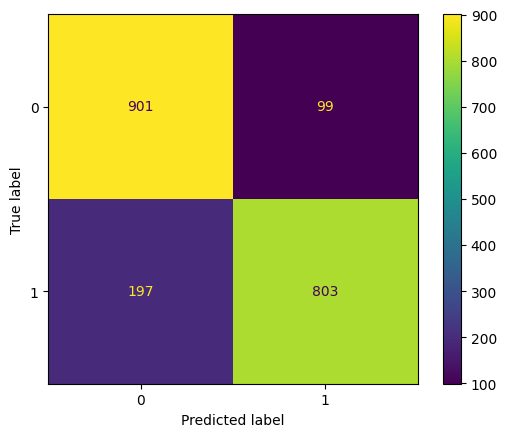

In [11]:
round_predictions = round_predictions_f(predictions, cost_fn)

cm = confusion_matrix(Y_test, round_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()